### CQA model with noise 

#### Noise

In [2]:
import qiskit 
import numpy as np 
import matplotlib.pyplot as plt
from typing import Optional, Union, List, Callable, Tuple
import pennylane as qml 
import networkx as nx
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from tqdm import tqdm
import jax 
import jax.numpy as jnp
import random
import optax 
from scipy.linalg import eigh

In [3]:
def getHam_square(lattice_size: Union[int, list], J: Optional[Union[list, int]], get_matrix: bool=False):
    '''
    Build the Heisenberg Hamiltonian 
    '''
    graph = nx.generators.lattice.grid_2d_graph(lattice_size[0],lattice_size[1])
    graph = nx.relabel.convert_node_labels_to_integers(graph)
    obs = []
    coeffs = []
    for edge in graph.edges():
        coeffs.extend([1.0, 1.0, 1.0])
        obs.extend([qml.PauliX(edge[0]) @ qml.PauliX(edge[1]),
                            qml.PauliY(edge[0]) @ qml.PauliY(edge[1]),
                            qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])])
    hamiltonian_heisenberg = qml.Hamiltonian(coeffs, obs) * J[0]
    if get_matrix: 
        # matrix = 0
        # for coeff, op in zip(hamiltonian_heisenberg.coeffs, hamiltonian_heisenberg.ops):
        #     # print(op.matrix())
        #     matrix += coeff * np.real(op.matrix()).astype('float64')
        matrix = qml.utils.sparse_hamiltonian(hamiltonian_heisenberg).real.toarray()
        return matrix.astype('float64')
    return hamiltonian_heisenberg

# ham_mat = getHam_square(myargs.lattice_size, myargs.J, get_matrix=True)
# # print(ham_mat.shape)
# E_gs, V_gs = eigh(ham_mat.astype('float64'), subset_by_index=[0,1])
# V_gs = V_gs[:,0]
# e_gs = E_gs[0]
# print(f'the complete spectrum: {E_gs}')
# print('True Ground state Energy via ED :--- ({}) '.format(e_gs))

## CQA ansatz 

#### CQA initialization

In [34]:
# state preparation:

def state_init(irrep: list):

    num_bell = 2*  (irrep[0] - abs(irrep[0] - irrep[1]))
    # num_comp = abs(irrep[0] - irrep[1])
    for i in range(0, num_bell-1):
        qml.PauliX(wires=i)
        if i %2 ==0:
            qml.Hadamard(wires=i)
            qml.CNOT(wires=[i,i+1]) 
    qml.PauliX(wires=num_bell-1) 

### Main ansatz

In [35]:
# Coxeter generators 

def coxeters(heis_params: jnp.array, layer:int, trotter_slice:int, num_qubits: int): 
    '''
    if p is even, return evens 
    if p is odd, return odds
    '''
    if layer % 2 == 0: 
        for j, i  in enumerate(range(num_qubits)):
            if i % 2 ==0 & i +1 < num_qubits:
                # print(f'j, i: {j, i}')
                swap = _swap2pauli(i, i+1, mode='ham')
                qml.ApproxTimeEvolution(swap, heis_params[int(j/2)], trotter_slice)
    elif layer % 2==1:
        for j, i in enumerate(range(num_qubits)):
            if i % 2 ==1 & i +1 < num_qubits:
                swap = _swap2pauli(i, i+1, mode='ham')
                qml.ApproxTimeEvolution(swap, heis_params[int((j-1)/2)], trotter_slice)


# Do the YJM (only first order so far on Pennylane)

def _swap2pauli(i: int, j:int, mode='ham'): 
    '''
    using the formula: SWAP(i j) = Si . Sj + 1/2 I (without I ) 
    '''
    if mode=='ham':
        coeff = np.ones(3)
        hamiltonian = [qml.PauliX(wires=i) @qml.PauliX(wires=j), 
                    qml.PauliY(wires=i) @qml.PauliY(wires=j),
                    qml.PauliZ(wires=i) @qml.PauliZ(wires=j) ]
        return qml.Hamiltonian(coeff, hamiltonian)
    elif mode=='list':
        hamiltonian = [qml.PauliX(wires=i) @qml.PauliX(wires=j), 
                    qml.PauliY(wires=i) @qml.PauliY(wires=j),
                    qml.PauliZ(wires=i) @qml.PauliZ(wires=j) ]
        return hamiltonian
        


def _get_YJM(idx:int):
    '''
    get YJM elements for a given index
    '''
    if idx == 0:
        print('too trivial choice')
        raise NotImplementedError
    elif idx ==1: 
        YJM = _swap2pauli(0,1, mode='ham')
        # print('---------')
        # print(YJM)
        return YJM
    else:
        swaps = []
        # yjm_lst = _swap2pauli(0, 1, mode='list')
        for i in range(idx):
            swaps.append(_swap2pauli(i, idx, mode='list'))
            # YJM += qml.SWAP(wires=[i, idx])
        # print(swaps)
        flat_yjm_lst = [item for sublist in swaps for item in sublist]
        # print(qml.Hamiltonian([1.0], [swaps[0]]))
        return qml.Hamiltonian(np.ones(len(flat_yjm_lst)), flat_yjm_lst)


def yjm_gates(yjm_params: jnp.array, trotter_slice:int, num_qubits:int, num_yjms:int):
    # num_yjms = int(np.floor(num_qubits /3))
    # selection = np.random.randint(1, args.num_qubits, args.num_yjms)
    selection = random.sample(range(1, num_qubits), num_yjms)
    for i, sel in enumerate(selection):
        YJM = _get_YJM(sel)
        qml.ApproxTimeEvolution(YJM, yjm_params[i], trotter_slice)

In [11]:
# plotting number of layers and number of parameter to reach good result as the system size varies

# lattice_size = [[2,2], [2,3], [2,4], [3,4], [4, 4]]
# irreps = [[2,2], [3,3], [4,4], [6, 6], [8, 8]]
# num_qubits = [4, 6, 8, 12, 16]
# J = [1.0, 0.0]
# num_yjms_lst = [3, 3, 3, 4, 6]
# trotter_slice = 1
# iterations = 30
# p = 2



### Simulating Noise

In [36]:
# Import all the hyper-parameters

class myargs: 
    def __init__(self) -> None:
        pass 

myargs.p =2
myargs.lr = 0.1
myargs.irrep = [2,2]
myargs.num_qubits = 4
myargs.num_yjms = 3
myargs.trotter_slice = 1
myargs.lattice_size = [2,2]
myargs.J = [1.0, 0.0]
myargs.iterations = 30
myargs.TOKEN = "4c84e8146c0def626bb384424f78598ee055148df74863d4cbad29fb99d5e9cd4808077115561b6490f6dc4a0f8014b24fe5985003cdbb88c17a51c80c55279a" 
myargs.backend = 'aer_simulator_statevector'
myargs.device = 0



ham_mat = getHam_square(myargs.lattice_size, myargs.J, get_matrix=True)
# print(ham_mat.shape)
E_gs, V_gs = eigh(ham_mat.astype('float64'), subset_by_index=[0,1])
V_gs = V_gs[:,0]
e_gs = E_gs[0]
print(f'the complete spectrum: {E_gs}')
print('True Ground state Energy via ED :--- ({}) '.format(e_gs))

the complete spectrum: [-8. -4.]
True Ground state Energy via ED :--- (-7.999999999999999) 


In [40]:
# Defining the CQA layer now 

def cqa_layers(params_dict:dict, trotter_slice:int=myargs.trotter_slice, p:int=myargs.p, num_qubits:int=myargs.num_qubits, num_yjms:int=myargs.num_yjms): 
    for layer in range(p):
        coxeters(params_dict['Heis'][layer], layer=layer, trotter_slice=trotter_slice, num_qubits=num_qubits)
        # var_ham_ans(params_dict['Heis'][layer,0], trotter_slice=trotter_slice)
        yjm_gates(params_dict['YJM'][layer], trotter_slice =trotter_slice, num_qubits=num_qubits, num_yjms=num_yjms)



def train_with_optimizer(cost_fn, optimizer: optax.GradientTransformation):
    '''
    update the gradient via jax 
    '''

    key = jax.random.PRNGKey(0)
    key1, key2 = jax.random.split(key)
    params_dict_init = {'YJM': jax.random.uniform(key1, (myargs.p, myargs.num_yjms)),
                    'Heis': jax.random.uniform(key2, (myargs.p,int(np.ceil(myargs.num_qubits/2))))}
    opt_state = optimizer.init(params_dict_init)
    loss_history, grad_history, param_history = [], [], [params_dict_init]
    # print('-------drawing the circuit--------')
    # drawer = qml.draw(cqa_circuit)
    # print(drawer(params_dict_init))
    # print(iteration)
    loss_grad_fn = jax.jit(jax.value_and_grad(cost_fn))
    for it in tqdm(range(1, myargs.iterations + 1)): 
        p_dict = param_history[-1]
        # print('p_dict | YJM: {} | Heis: {}'.format(p_dict['YJM'], p_dict['Heis']))
        loss, gradient = loss_grad_fn(p_dict)
        updates, opt_state = optimizer.update(gradient, opt_state, p_dict)
        # print(f'gradient: {gradient}')
        # print("Step {:3d}   Cost_L = {:9.7f}".format(it, loss))
        updated_p_dict = optax.apply_updates(p_dict, updates)
        # updated_p_dict = {'YJM': p_dict['YJM'] - myargs.lr * gradient['YJM'],
        #                 'Heis': p_dict['Heis'] - myargs.lr * gradient['Heis']}
        param_history.append(updated_p_dict)
        loss_history.append(loss)
        grad_history.append(gradient)
        if jnp.abs(loss - e_gs) < 0.05:
            print('desired convergence is reached')
            return loss_history, param_history, grad_history
        # if jnp.linalg.norm(gradient['Heis']) / gradient['Heis'].size < 1e-6:
        #     print(gradient['Heis'])
        #     print('encountering the Barren Plateau')
        #     break
    return loss_history, param_history, grad_history

In [58]:
qiskit.IBMQ.disable_account()

 33%|███▎      | 10/30 [58:11<1:56:22, 349.13s/it]

desired convergence is reached


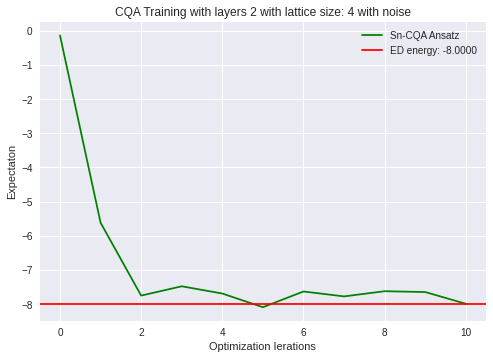

In [59]:
# Simulating with real IBM noise model on 4 quibts model

provider = qiskit.IBMQ.enable_account(myargs.TOKEN, hub='ibm-q-startup', group='qbraid', project='main')
# backend = provider.get_backend(myargs.backend)
# noise_model = NoiseModel.from_backend(backend)  
dev_mu = qml.device('qiskit.aer', wires = myargs.num_qubits, noise_model=None, shots=500,  backend= 'aer_simulator_statevector')
# qiskit.IBMQ.disable_account()

@qml.qnode(dev_mu, interface='jax')
def cqa_circuit(params_dict: dict, check_symmetry:bool=False, trotter_slice:int=myargs.trotter_slice):
    state_init(myargs.irrep)
    cqa_layers(params_dict, trotter_slice=trotter_slice)
    # hamiltonian = getHam_square(myargs.lattice_size, myargs.J)
    if check_symmetry is False:
        hamiltonian = getHam_square(myargs.lattice_size, myargs.J) 
        return qml.expval(hamiltonian)
    else: 
        su2_pauli = qml.PauliZ(0)
        for i in range(1, myargs.num_qubits):
            su2_pauli = su2_pauli @ qml.PauliZ(i) 
        return qml.expval(su2_pauli), qml.expval(qml.Identity(wires=0)) 

optimizer = optax.adamw(learning_rate=myargs.lr)
loss_history_noise, param_history_noise, grad_history_noise = train_with_optimizer(cqa_circuit, optimizer)
ham_mat = getHam_square(myargs.lattice_size, myargs.J, get_matrix=True)
# print(ham_mat.shape)
plt.style.use("seaborn")
plt.plot(loss_history_noise, "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Expectaton")
plt.xlabel("Optimization Ierations")
plt.legend(loc="upper right")
plt.title(f'CQA Training with layers {myargs.p} with lattice size: {myargs.num_qubits} with noise') 
plt.show()

In [26]:
loss_history_noise_shot10 = jnp.array(loss_history_noise)


DeviceArray([-2.2      , -6.6      , -1.8      , -1.       , -6.2      ,
             -6.2000003, -2.4      , -6.2      , -4.8      , -7.6000004,
             -7.7999997, -7.4      , -6.600001 , -6.2000003, -9.       ,
             -6.8      , -7.4      , -7.0000005, -6.6000004, -5.2      ,
             -7.2      , -5.8      , -7.6      , -7.3999996],            dtype=float32)

In [47]:
loss_history_noise_shot1000 = jnp.array(loss_history_noise)
print(loss_history_noise_shot1000)

[-0.506     -5.2139997 -7.156     -7.5919995 -6.8639994 -6.68
 -7.566     -8.023999 ]


In [52]:
loss_history_noise_shot50 = jnp.array(loss_history_noise)
loss_history_noise_shot50

DeviceArray([-5.52     , -5.2799997, -5.2400002, -6.9600005, -7.7599998,
             -7.9600005], dtype=float32)

In [56]:
loss_history_noise_shot100= jnp.array(loss_history_noise)
loss_history_noise_shot100

DeviceArray([-0.67999995, -5.96      , -6.8199997 , -7.08      ,
             -7.54      , -7.96      ], dtype=float32)

In [60]:
loss_history_noise_shot500 = jnp.array(loss_history_noise)
print(loss_history_noise_shot500)

[-0.136     -5.6160007 -7.7479997 -7.4760003 -7.6880007 -8.088
 -7.628     -7.7719994 -7.6199994 -7.644     -7.9880004]


In [23]:
loss_dict_noise = {}
loss_dict_noise[10] = jnp.array([-2.2      , -6.6      , -1.8      , -1.       , -6.2      ,-6.2000003, -2.4      , -6.2      , -4.8      , -7.6000004,
             -7.7999997, -7.4      , -6.600001 , -6.2000003, -9.       ,
             -6.8      , -7.4      , -7.0000005, -6.6000004, -5.2      ,
             -7.2      , -5.8      , -7.6      , -7.3999996])
loss_dict_noise[50] = jnp.array([-5.52     , -5.2799997, -5.2400002, -6.9600005, -7.7599998,
             -7.9600005])
loss_dict_noise[100] = jnp.array([-0.67999995, -5.96      , -6.8199997 , -7.08      ,
             -7.54      , -7.96      ])
loss_dict_noise[500] = jnp.array([-0.136, -5.6160007, -7.747997, -7.4760003, -7.6880007, 
-8.088, -7.628, -7.7719994, -7.6199994, -7.644, -7.9880004])
    

loss_dict_noise[1000] = jnp.array([-0.506, -5.2139997, -7.156, -7.5919995, -6.8639994, -6.68, -7.566, -8.023999])

print(jnp.min(loss_dict_noise[10]))

-9.0


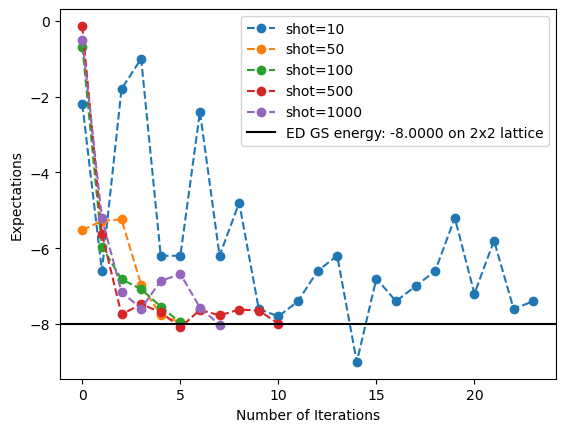

In [24]:
plt.style.use("default")
plt.plot([i for i in range(len(loss_dict_noise[10]))], loss_dict_noise[10] , "o", linestyle='--', label='shot=10')
plt.plot([i for i in range(len(loss_dict_noise[50]))], loss_dict_noise[50] , "o", linestyle='--', label='shot=50')
plt.plot([i for i in range(len(loss_dict_noise[100]))], loss_dict_noise[100] , "o", linestyle='--', label='shot=100')
plt.plot([i for i in range(len(loss_dict_noise[500]))], loss_dict_noise[500] , "o", linestyle='--', label='shot=500')
plt.plot([i for i in range(len(loss_dict_noise[1000]))], loss_dict_noise[1000] , "o", linestyle='--', label='shot=1000')
plt.axhline(-8.0, color='k', linestyle='-', label='ED GS energy: {:.4f} on 2x2 lattice'.format(-8.0))
# plt.axvline(3, color='k', linestyle='--', label='optimal')
plt.ylabel("Expectations")
plt.xlabel("Number of Iterations")
plt.legend(loc="best")
# plt.title(f'') 
plt.show()

In [27]:
data1 = np.load('/local/hanzheng/CQA/Sn_CQA/pennylane_codes/loss_with_[2, 2].npy') # 15, 4, 1
data1

array([-3.59390738, -6.79560721, -5.98313549, -5.66192893, -6.83048451,
       -6.19338846, -6.80744243, -6.45733116, -6.74820368, -6.81970928,
       -6.58242617, -6.95547101, -6.82813474, -6.75099367, -6.96007508,
       -6.94178316, -6.83947051, -6.8518134 , -6.97789285, -6.96811425,
       -6.92082881, -6.91971515, -6.99489809, -6.9652965 , -6.92535387,
       -6.97030063, -6.99704109, -6.95632304, -6.9529652 , -6.98922101,
       -6.99534034, -6.968676  , -6.97614897, -6.99823477, -6.99307584,
       -6.97992675, -6.98511589, -6.99771753, -6.9979041 , -6.98878502,
       -6.98871692, -6.99701365, -6.99968682, -6.99489971, -6.99250082,
       -6.99630913, -6.99992194, -6.99815024, -6.99511989, -6.99626662,
       -6.99938199, -6.99956237, -6.99739113, -6.99707329, -6.99907306,
       -6.99995379, -6.99862507, -6.99790137, -6.99910716, -6.99999833,
       -6.99925247, -6.99859745, -6.999284  , -6.99998956, -6.99956332,
       -6.99906435, -6.9995013 , -6.99999176, -6.99970245, -6.99

In [28]:
data2 = np.load('/local/hanzheng/CQA/Sn_CQA/pennylane_codes/loss_with_[2, 3].npy') # 52, 6, 4
data2

array([ -4.3139779 ,  -5.41276435,  -6.02685255,  -6.14804264,
        -7.62424117,  -7.26864109,  -6.9993603 ,  -6.87957264,
        -9.37584424,  -8.77396612,  -8.26204821,  -9.82468986,
        -8.67420341,  -9.34997458,  -8.72008799,  -9.23814506,
        -9.84390668,  -9.17011044, -10.10821884,  -9.36123136,
       -10.18960422,  -9.91810642,  -9.77186082, -10.04788076,
       -10.00414872, -10.13015848, -10.20196289, -10.11617734,
       -10.34040669, -10.21176582, -10.16329935, -10.37258799,
       -10.29006792, -10.35030127, -10.34319511, -10.31688845,
       -10.37924795, -10.33687964, -10.40799895, -10.39744264,
       -10.39011632, -10.45034567, -10.39125907, -10.41436235,
       -10.42661051, -10.43359141, -10.43942684, -10.43987658,
       -10.44433653, -10.44750483, -10.44275105, -10.45828215,
       -10.43671838, -10.45767252, -10.46237318, -10.45409714,
       -10.45965549, -10.46150942, -10.4589459 , -10.46419239,
       -10.45930379, -10.46606001, -10.46369951, -10.46

In [29]:
data3 = np.load('/local/hanzheng/CQA/Sn_CQA/pennylane_codes/loss_with_[2, 4].npy') # 59, 6, 4
data3

array([ -6.61585326,  -6.84615515,  -8.05463829,  -6.40288871,
        -7.77410476,  -6.91332091,  -7.01511749,  -7.23909658,
        -9.19704337,  -8.29071659,  -8.64189665,  -9.53097727,
       -10.31112867, -10.25364142,  -9.88786069, -10.25613264,
       -11.64690768, -11.47305341, -11.46980667, -11.80579435,
       -11.39281748, -11.85158033, -11.77486025, -12.11399712,
       -12.39216678, -12.38711093, -12.72945918, -12.92031799,
       -13.11801968, -13.3790373 , -13.34537063, -13.07462067,
       -12.926849  , -13.64259746, -13.81219854, -13.86856261,
       -13.86267599, -13.73282786, -13.95980197, -13.93397559,
       -13.9206213 , -13.90504871, -13.97597534, -14.02296689,
       -14.02676757, -14.21784613, -14.16190269, -14.12621247,
       -14.01351426, -13.99139744, -13.92257892, -13.97641521,
       -14.15177245, -14.10033544, -13.96210512, -13.96200511,
       -14.28078972, -14.24027725, -14.08796398, -14.04036027,
       -14.25348554, -14.32938223, -14.21240248, -14.12

In [33]:
data4 = np.load('/local/hanzheng/CQA/Sn_CQA/pennylane_codes/loss_with_[3, 4].npy') # 59, 6, 4

np.min(data4)

-24.475222191732897